In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

from pymc3 import traceplot

import glam

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test Case 2: Within-participant design

In the second test case we demonstrate the use of the model for a within-participant design. Here, each participant performs multiple conditions that are hypothesized to affect participants' gaze bias $\gamma$ and general processing speed $v$. There are four conditions in total:

1. High Bias &  Fast Speed
2. High Bias &  Slow Speed
3. Low Bias & Fast Speed
4. Low Bias & Slow Speed

# Simulating data

First, we simulate data of 20 participants, with 50 trials in each condition.

In [15]:
# Set the random seed, so that we can re-create exactly the same data, if we need to
np.random.seed(3)

# Setup up the GLAM instance
model = glam.GLAM()

# There are 20 participants in total
N = 20

# Every participant performed 100 trials of each condition
n_trials = 250
n_items = 3

# The conditions differ in their mean gaze-bias parameter
gamma = dict(high=np.clip(np.random.normal(loc=-0.5, scale=0.2, size=N), -1.0, 1.0),
             low=np.clip(np.random.normal(loc=0.6, scale=0.2, size=N), -1.0, 1.0))
print('high gamma mean:', gamma['high'].mean())
print('low gamma mean:', gamma['low'].mean())

# and processing speed
v = dict(fast=np.clip(np.random.normal(loc=0.0001, scale=0.00001, size=N), 1e-6, 0.01),
         slow=np.clip(np.random.normal(loc=0.00006, scale=0.00001, size=N), 1e-6, 0.01))
print('fast v mean:', v['fast'].mean().round(5))
print('slow v mean:', v['slow'].mean().round(5))

# other parameters are constant across conditions:
s = np.clip(np.random.normal(loc=0.008, scale=0.002, size=N), 1e-8, 0.02)
tau = np.clip(np.random.normal(loc=0.8, scale=0.05, size=N), 0.1, 3)
t0 = np.zeros(N)

# We now simulate data for each group, using the specific group details, we set up
for bias in ['high', 'low']:
    for speed in ['fast', 'slow']:
        model.simulate_group(kind='individual',
                             n_individuals=N,
                             parameters=dict(gamma=gamma[bias],
                                             v=v[speed],
                                             s=s,
                                             tau=tau,
                                             t0=t0),
                             n_items=n_items,
                             n_trials=n_trials,
                             label=bias + '_' + speed,
                             individual_idx=np.arange(N)) # note the use of the individual_idx keyword, to simulate within-participant data

model.data.head()

high gamma mean: -0.518083149493
low gamma mean: 0.547334278714
fast v mean: 0.0001
slow v mean: 6e-05


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,condition
0,0.0,0.0,1560.0,0.0,0.0,7,0.525801,6,0.316297,7,0.157902,high_fast
1,1.0,0.0,871.0,0.0,1.0,9,0.391448,1,0.540411,5,0.068141,high_fast
2,2.0,0.0,1430.0,0.0,2.0,7,0.264177,5,0.298670,9,0.437154,high_fast
3,2.0,0.0,1653.0,0.0,3.0,7,0.029875,2,0.396976,6,0.573149,high_fast
4,1.0,0.0,1487.0,0.0,4.0,4,0.302952,8,0.395592,4,0.301456,high_fast


(array([ 2.,  1.,  1.,  2.,  3.,  2.,  3.,  1.,  2.,  3.]),
 array([  4.60423650e-05,   4.93771069e-05,   5.27118489e-05,
          5.60465909e-05,   5.93813328e-05,   6.27160748e-05,
          6.60508168e-05,   6.93855587e-05,   7.27203007e-05,
          7.60550426e-05,   7.93897846e-05]),
 <a list of 10 Patch objects>)

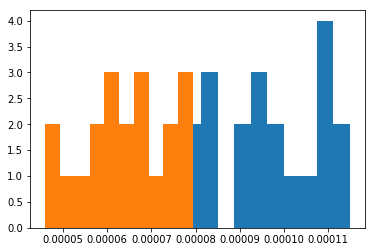

In [16]:
plt.hist(v['fast'])
plt.hist(v['slow'])

(array([ 1.,  1.,  4.,  1.,  2.,  1.,  3.,  3.,  2.,  2.]),
 array([ 0.73532317,  0.74851581,  0.76170846,  0.7749011 ,  0.78809375,
         0.8012864 ,  0.81447904,  0.82767169,  0.84086433,  0.85405698,
         0.86724962]),
 <a list of 10 Patch objects>)

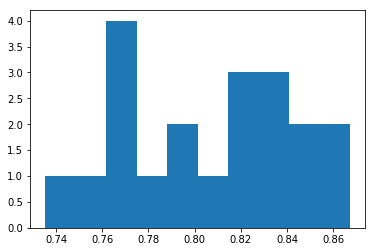

In [17]:
plt.hist(tau)

(array([ 1.,  0.,  0.,  4.,  5.,  3.,  4.,  1.,  1.,  1.]),
 array([ 0.00216852,  0.0031833 ,  0.00419808,  0.00521286,  0.00622763,
         0.00724241,  0.00825719,  0.00927197,  0.01028674,  0.01130152,
         0.0123163 ]),
 <a list of 10 Patch objects>)

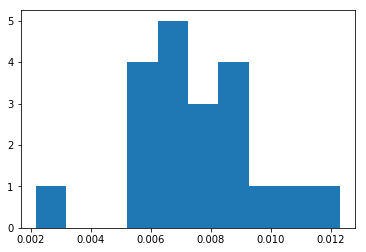

In [19]:
plt.hist(s)

The simulation method currently does not support direct coding of multiple-factor designs. The `condition` variable in the data frame currently codes both factors and therefore needs to be split into two columns:

In [20]:
model.data['bias'], model.data['speed'] = model.data['condition'].str.split('_', 1).str
model.data.head()

,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,condition,bias,speed
0,0.0,0.0,1560.0,0.0,0.0,7,0.525801,6,0.316297,7,0.157902,high_fast,high,fast
1,1.0,0.0,871.0,0.0,1.0,9,0.391448,1,0.540411,5,0.068141,high_fast,high,fast
2,2.0,0.0,1430.0,0.0,2.0,7,0.264177,5,0.298670,9,0.437154,high_fast,high,fast
3,2.0,0.0,1653.0,0.0,3.0,7,0.029875,2,0.396976,6,0.573149,high_fast,high,fast
4,1.0,0.0,1487.0,0.0,4.0,4,0.302952,8,0.395592,4,0.301456,high_fast,high,fast


# Exploring data

Next, we look at the behavioral data, by plotting the data separately for the speed & bias conditions. The aggregate data are plotted in black, whereas condition-specific data are plotted in color.

From left to right, we see: (A) mean response times (in ms), (B) mean probability of choosing the left item as a function of the item's liking rating, (C) mean probability of choosing the left item as a function of the difference between the item's gaze and the mean gaze of all other items, (D) mean probability of choosing the left item as a function of the difference between the item's gaze and the mean gaze of all other items, when corrected for the influence of item rating on choice probability (for further details, see Thomas, Molter, Krajbich, Heekeren & Mohr, 2017).

### Fast & Slow Speed

As expected, the data data of both speed-conditions matchs in all analyses, except for the response times (panel A).

(<matplotlib.figure.Figure at 0x1c1caae898>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c54a160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c1d4c4b70>], dtype=object))

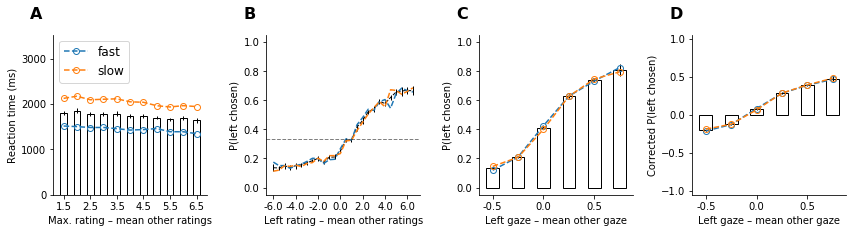

In [21]:
glam.plot_fit(model.data, [model.data[model.data['speed'] == 'fast'],
                           model.data[model.data['speed'] == 'slow']],
              prediction_labels=['fast', 'slow'])

### High & Low Bias

Similarly, the data  in both bias-conditions matches in response times, but differs in all analysis of the gaze bias (C - D). 

Interestingly, there is also a substantial difference between both bias-groups in their probability of choosing an item, given the item's rating value (B). This relationship can be explained as follows: if (1) an individual's choices are strongly dependent on the allocation of gaze during the decision process, and (2) the gaze of the individual is allocated independent of the items' rating values, then the effect of item rating on the individuals' choices can be suppressed by the strong association of gaze and choice. Therefore, we expect individuals to have a lower association of item rating and choice, if their association of gaze and choice is strong and their gaze is distributed independent of item rating.

(<matplotlib.figure.Figure at 0x1c1cabad68>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d372a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c1d426fd0>], dtype=object))

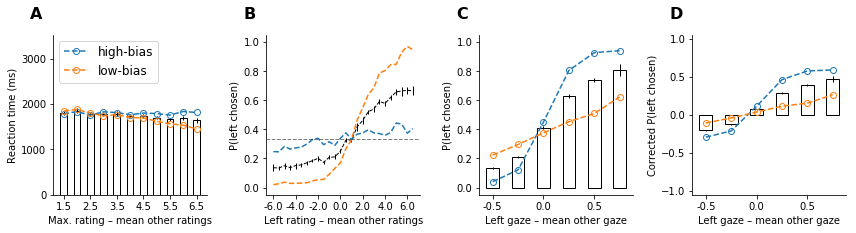

In [22]:
glam.plot_fit(model.data, [model.data[model.data['bias'] == 'high'],
                           model.data[model.data['bias'] == 'low']],
              prediction_labels=['high-bias', 'low-bias'])

# Model fitting

### Model set up

Next, we need to specify the exact model to fit to the data. We need to indicate that the gaze-bias parameter $\gamma$ shall depend on the `bias` condition of our data, and the velocity parameter $v$ on the `speed` condition.

We also have to choose whether we want to fit the model hierarchically to all of our participants, or to each individual participant alone. We choose the hierarchical model here.

In [23]:
model.make_model(kind='hierarchical',
                 depends_on=dict(gamma='bias',
                                 v='speed'),
                 t0_val=0) # we did not simulate any non-decision time and therefore fix t0 = 0

Generating hierarchical model for 20 subjects...


### Parameter estimation

The model is specified. Now the parameters can be estimated. `GLAMbox` implements the model as a `pymc3` model object, that can be fit with all fitting procedures included in `pymc3`. For large hierarchical models in particular, we made the experience that automatic differentiation variational inference (ADVI; Kucukelbir,  Ranganath, Gelman & Blei, 2015) performs well and fast.

In [24]:
model.fit(method='ADVI', n_advi=50000)

Fitting 1 model(s) using ADVI...
  Fitting model 1 of 1...


Average Loss = 1.6628e+05:  84%|████████▍ | 42102/50000 [30:34<05:44, 22.95it/s]
Interrupted at 42,102 [84%]: Average Loss = 1.7289e+05


/!\ Automatically setting parameter precision...


## Analysis

### Parameter recovery

Now that the model parameters are estimated, we want to test whether the model properly recovered the group-specific condition parameters (i.e. $v$ and $\gamma$). 

After fitting, the `GLAM` model instance automatically extracts posterior modes for every estimated parameter. However, in order to make full use of the Bayesian parameter estimation procedure, the `pymc3` trace object is also attached to the model instance (note that in the case of variational inference, this trace is simply being sampled using the estimated variational parameters. It is not the result of an MCMC algorithm, as would be obtained if estimation would have been done using traditional sampling techniques like Metropolis or NUTS sampling).

Nevertheless, we see that the model correctly estimates and separates our empricial gaze-biase (i.e. $\gamma$) group means.

Text(0.5,1,'Posterior of $\\gamma$ group means')

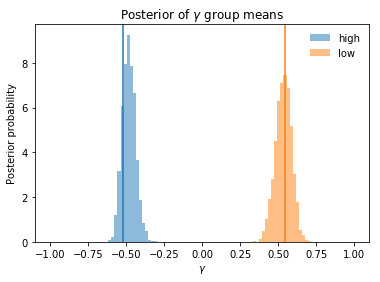

In [32]:
bins = np.linspace(-1, 1, 100)

fig, ax = plt.subplots()

for i, bias in enumerate(['high', 'low']):
    ax.hist(model.trace['gamma_{}_mu'.format(bias)], bins=bins,
            histtype='stepfilled', alpha=0.5, color='C{}'.format(i),
            label=bias, normed=True)
    
    ax.axvline(gamma[bias].mean(), color='C{}'.format(i))
    
ax.legend(frameon=False)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Posterior probability')
ax.set_title(r'Posterior of $\gamma$ group means')

Similarly, we see that the model correctly estimates and separates our empricial speed (i.e. $v$) group means.

Text(0.5,1,'Posterior of $v$ group means')

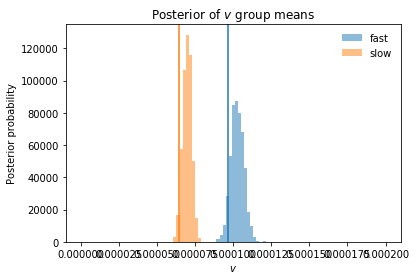

In [33]:
bins = np.linspace(0, 0.0002, 100)

fig, ax = plt.subplots()

for i, speed in enumerate(['fast', 'slow']):
    ax.hist(model.trace['v_{}_mu'.format(speed)], bins=bins,
            histtype='stepfilled', alpha=0.5, color='C{}'.format(i),
            label=speed, normed=True)
    
    ax.axvline(v[speed].mean(), color='C{}'.format(i))
    
ax.legend(frameon=False)
ax.set_xlabel(r'$v$')
ax.set_ylabel('Posterior probability')
ax.set_title(r'Posterior of $v$ group means')

Text(0.5,1,'Posterior of $\\tau$ group means')

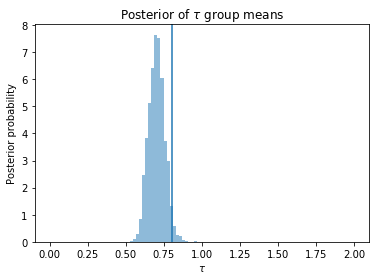

In [34]:
bins = np.linspace(0, 2, 100)

fig, ax = plt.subplots()

ax.hist(model.trace['tau_mu'], bins=bins,
        histtype='stepfilled', alpha=0.5,
        normed=True)

ax.axvline(tau.mean())
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Posterior probability')
ax.set_title(r'Posterior of $\tau$ group means')

Text(0.5,1,'Posterior of $\\sigma$ group means')

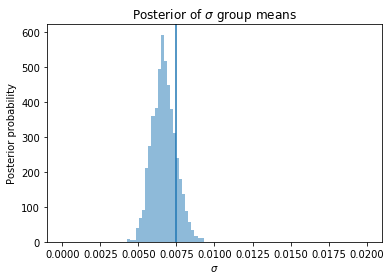

In [35]:
bins = np.linspace(0, 0.02, 100)

fig, ax = plt.subplots()

ax.hist(model.trace['s_mu'], bins=bins,
        histtype='stepfilled', alpha=0.5,
        normed=True)

ax.axvline(s.mean())

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('Posterior probability')
ax.set_title(r'Posterior of $\sigma$ group means')

### Prediction

Next, we can test the aboslute fit of the estimated model, by simulating response data with our parameter estimates and plotting them against the previously simulated data that was used to estimate the model parameters.

In [12]:
raise NotImplementedError('The following does not work because our prediction function does not index parameter by condition.')

NotImplementedError: The following does not work because our prediction function does not index parameter by condition.

In [ ]:
# for the simulation, we repeat each trial of the original dataset 10 times.
model.predict(n_repeats=10)
predicted_data = model.predictions

model.prediction.head()

### Goodnes of fit

To test the goodness of fit of these predictions, we again plot the predicted data against our original data. This time, separately within each of the 4 conditoins

#### High Bias & Fast Speed

In [ ]:
glam.plot_fit(model.data[np.logical_and(model.data['speed'] == 'fast',
                                        model.data['bias'] == 'high')],
              [model.predictions[np.logical_and(model.predictions['speed'] == 'fast',
                                                model.predictions['bias'] == 'high')]])

#### High Bias & Slow Speed

In [ ]:
glam.plot_fit(model.data[np.logical_and(model.data['speed'] == 'slow',
                                        model.data['bias'] == 'high')],
              [model.predictions[np.logical_and(model.predictions['speed'] == 'slow',
                                                model.predictions['bias'] == 'high')]])

#### Low Bias & Fast Speed

In [ ]:
glam.plot_fit(model.data[np.logical_and(model.data['speed'] == 'fast',
                                        model.data['bias'] == 'low')],
              [model.predictions[np.logical_and(model.predictions['speed'] == 'fast',
                                                model.predictions['bias'] == 'low')]])

#### Low Bias & Slow Speed

In [ ]:
glam.plot_fit(model.data[np.logical_and(model.data['speed'] == 'slow',
                                        model.data['bias'] == 'low')],
              [model.predictions[np.logical_and(model.predictions['speed'] == 'slow',
                                                model.predictions['bias'] == 'low')]])

# References

- Kucukelbir, A., Ranganath, R., Gelman, A., & Blei, D. M. (2015). Automatic Variational Inference in Stan. ArXiv:1506.03431 [Stat]. Retrieved from http://arxiv.org/abs/1506.03431

- Armin W. Thomas & Felix Molter, Ian Krajbich, Hauke R. Heekeren, Peter N. C. Mohr (2017)
bioRxiv 228825; doi: https://doi.org/10.1101/228825